### RNN with Attention vs. DistillBERT
기존 RNN 모델에서 Attention을 추가한 것과 BERT 모델과의 단순 분류를 비교하는 Task입니다. <br> <br>
참고 자료 <br>
https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3

라이브러리 확인

In [ ]:
!pip install --upgrade pandas==1.4.4 numpy==1.24.4 tensorflow==2.10.0 transformers==4.21.0 gensim==4.2.0

^C


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.0 MB 932.9 kB/s eta 0:00:11
   -- ------------------------------------- 0.5/10.0 MB 932.9 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/10.0 MB 671.3 kB/s eta 0:00:14
   --- ------------------------------------ 0.8/10.0 MB 671.3 kB/s eta 0:00:14
   ---- ----------------------------------- 1.0/10.0 MB 636.8 kB/s eta 0:00:15
   ---- ----------------------------------- 1.0/10.0 MB 636.8 kB/s eta 0:00:15
   ----- ---------------------------------- 1.3/10.0 MB 691.7 kB/s eta 0:00:13
   ----- ---------------------------------- 1.3/10.0 MB 691.7 kB/s eta 0:00:13
   ----- ---------------------------------- 1.3/10.0 MB 691.7 kB/s eta 0:00:13
   ------

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

import transformers

# Visualization
import matplotlib
from matplotlib import pyplot as plt

# Text processing
import re
import nltk
import gensim
import gensim.downloader as api

# Various
from datetime import datetime

# Showing the versions used
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('PyPlot version: {}'.format(matplotlib.__version__))
print('Scikit Learn version: {}'.format(sklearn.__version__))
print('Tensorflow version: {}'.format(tf.__version__))
print('Transformers version: {}'.format(transformers.__version__))
print('Regex version: {}'.format(re.__version__))
print('NLTK version: {}'.format(nltk.__version__))
print('Gensim version: {}'.format(gensim.__version__))


Pandas version: 1.4.4
Numpy version: 1.24.4
PyPlot version: 3.9.2
Scikit Learn version: 1.5.2
Tensorflow version: 2.10.0
Transformers version: 4.21.0
Regex version: 2.2.1
NLTK version: 3.9.1
Gensim version: 4.2.0


### 비교를 위한 데이터셋 로드
데이터 셋은 hugggingface에서 가져왔으므로 아래와 같이 불러옵니다. <br>
추가로 해당 데이터 셋은 train 데이터 셋과 test 데이터 셋이 있으므로 각각 불러옵니다. <br>

In [ ]:
from datasets import load_dataset
dataset = load_dataset("fancyzhx/ag_news")
train_dataset = dataset["train"].to_pandas()
test_dataset = dataset["test"].to_pandas()

# 데이터 확인
train_dataset.head()
test_dataset.head()

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [ ]:
# 학습 데이터 확인
print('Total number: {}'.format(len(train_dataset)))
print(40*'-')
print('Train Dataset : Split by label:')
print(train_dataset["label"].value_counts())
print(40*'-')
nr_categories = len(train_dataset["label"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number: 120000
----------------------------------------
Train Dataset : Split by label:
2    30000
3    30000
1    30000
0    30000
Name: label, dtype: int64
----------------------------------------
Number of categories: 4


In [ ]:
# 테스트 데이터 확인
print('Total number: {}'.format(len(test_dataset)))
print(40*'-')
print('Validation Dataset : Split by label:')
print(test_dataset["label"].value_counts())
print(40*'-')
nr_categories = len(test_dataset["label"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number: 7600
----------------------------------------
Validation Dataset : Split by label:
2    1900
3    1900
1    1900
0    1900
Name: label, dtype: int64
----------------------------------------
Number of categories: 4


In [ ]:
# 데이터의 일부 확인 (100번째 데이터)
n=100
print('label: ',train_dataset['label'][n])
print(100*'-')
print('Text:')
print(train_dataset['text'][n])

label:  3
----------------------------------------------------------------------------------------------------
Text:
Comets, Asteroids and Planets around a Nearby Star (SPACE.com) SPACE.com - A nearby star thought to harbor comets and asteroids now appears to be home to planets, too. The presumed worlds are smaller than Jupiter and could be as tiny as Pluto, new observations suggest.


## Deep Learning - RNN
RNN을 이용하여 학습을 하기 전에 전처리 작업을 진행해줍니다. <br>
**데이터 전처리** : text와 label 칼럼 선택, LabelBinarizer를 이용하여 원-핫 인코딩 <br>
**테스트 데이터 불러오기** : HuggingFace에서 test 데이터 셋이 있어 train 셋을 분리하지 않고 불러옵니다. <br>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# 텍스트와 레이블 컬럼 선택
X_train = train_dataset["text"]  # Train 텍스트 데이터
y_train_class = train_dataset["label"]  # Train 라벨 (0~3)

X_test = test_dataset["text"]  # Test 텍스트 데이터
y_test_class = test_dataset["label"]  # Test 라벨 (0~3)

# 원-핫 인코딩 (4개 클래스: 0, 1, 2, 3)
lab = LabelBinarizer()
lab.fit(y_train_class)  # Train 데이터에 대해 인코더 학습
y_train = lab.transform(y_train_class)
y_test = lab.transform(y_test_class)

# 데이터 크기 확인
print(f"Train data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")

# Example (라벨 변환 확인)
n = 0  # 예시 데이터
print(f'Coding of labels into a one-hot vector: {y_train_class[n]} is {y_train[n]}')

Train data size: 120000
Test data size: 7600
Coding of labels into a one-hot vector: 2 is [0 0 1 0]


RNN에서는 토크나이저가 따로 없기 때문에 직접 설계하였습니다. <br>
Keras의 Tokenizer로 텍스트를 숫자로 변형합니다. <br>

In [ ]:
corpus = X_train.tolist()
max_words = 15000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = {index: word for word, index in voc.items()}
print(f"단어 사전에 저장된 단어 수: {len(voc)}")
print(f"단어 예제: {list(voc.keys())[:10]}")

단어 사전에 저장된 단어 수: 70345
단어 예제: ['<pad>', 'the', 'to', 'a', 'of', 'in', 'and', 'on', 'for', '39']


In [ ]:
max_len = 100 # 최대의 길이를 불러오도록 설정

sequences = tokenizer.texts_to_sequences(X_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (120000, 100)
----------------------------------------------------------------------------------------------------
Example:  [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0    54     7   377  4577     1   767    18    69    22  2427   463
    91  1905  1284    67     2   377     7     2   767     9   285    41
   192     3  5812    35     2   297   129   112    83   234     2  6205
     5     2  1215 14994]


### Attention을 적용하는 RNN 구성 설명
모델은 아래의 예시에서 사용하는 모델에 Attention 메커니즘을 적용하였습니다. <br>
예시 : https://github.com/feldges/Classification/blob/main/Classification.ipynb
1. Word2Vec 기반의 임베딩 벡터로 입력데이터 변환
2. 양방향 시퀀스 처리로 문맥 정보 학습
3. Attention을 추가하여 Context Vector 생성
4. Fully connected layer를 통과하여 최종 분류를 진행

In [ ]:
w2v = api.load("word2vec-google-news-300") # Word2Vec 임베딩 벡터 로드
print(w2v['hello'].shape)

# 임베딩 행렬 생성
emb_matrix = np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1, :] = w2v[w]
emb_size = emb_matrix.shape[1]

(300,)


In [ ]:
# Input layer
input_ = layers.Input(shape=(X_tf_train_seq.shape[1],), name='input')

# Embedding layer using pre-trained Word2Vec weights
x = layers.Embedding(input_dim=max_words+1,output_dim=emb_size,weights=[emb_matrix],trainable=False,name='embedding')(input_)

# Simple RNN Layer (returning sequences for Attention)
x = layers.Bidirectional(layers.LSTM(15, return_sequences=True, dropout=0.2), name='bidirectional-lstm')(x)

# Attention mechanism
attention_weights = layers.Dense(1, activation='tanh')(x)  # Compute attention scores
attention_weights = layers.Softmax(axis=1, name='attention_weights')(attention_weights)  # Normalize scores
context_vector = layers.Dot(axes=1, name='context_vector')([attention_weights, x])  # Weighted sum
context_vector = layers.Flatten(name='flatten')(context_vector)  # Flatten for fully connected layers

# Fully connected layers
x = layers.Dropout(0.2, name='fc_dropout')(context_vector)
x = layers.Dense(64, activation='relu', name='fc_dense')(x)

# Output layer
output = layers.Dense(nr_categories, activation='softmax', name='classification')(x)

# Model definition
model = models.Model(input_, output)

# Compile the model
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary() # 모델 구성 확인

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     4500300     ['input[0][0]']                  
                                                                                                  
 bidirectional-lstm (Bidirectio  (None, 100, 30)     37920       ['embedding[0][0]']              
 nal)                                                                                             
                                                                                                  
 dense_2 (Dense)                (None, 100, 1)       31          ['bidirectional-lstm[0][0]

In [ ]:
# Train the model
start_time = datetime.now()
history = model.fit(X_tf_train_seq, y_train, batch_size=64, shuffle=True, epochs=5, validation_data=(X_tf_test_seq, y_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

print(f"Training Time: {training_time_rnn} seconds")

Epoch 1/5
1875/1875 [==============================] - 26s 13ms/step - loss: 0.3210 - accuracy: 0.8909 - val_loss: 0.2921 - val_accuracy: 0.9043
Epoch 2/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2644 - accuracy: 0.9100 - val_loss: 0.2670 - val_accuracy: 0.9101
Epoch 3/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2480 - accuracy: 0.9148 - val_loss: 0.2641 - val_accuracy: 0.9113
Epoch 4/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2411 - accuracy: 0.9164 - val_loss: 0.2576 - val_accuracy: 0.9155
Epoch 5/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.2324 - accuracy: 0.9197 - val_loss: 0.2492 - val_accuracy: 0.9172
Training Time: 122.350953 seconds


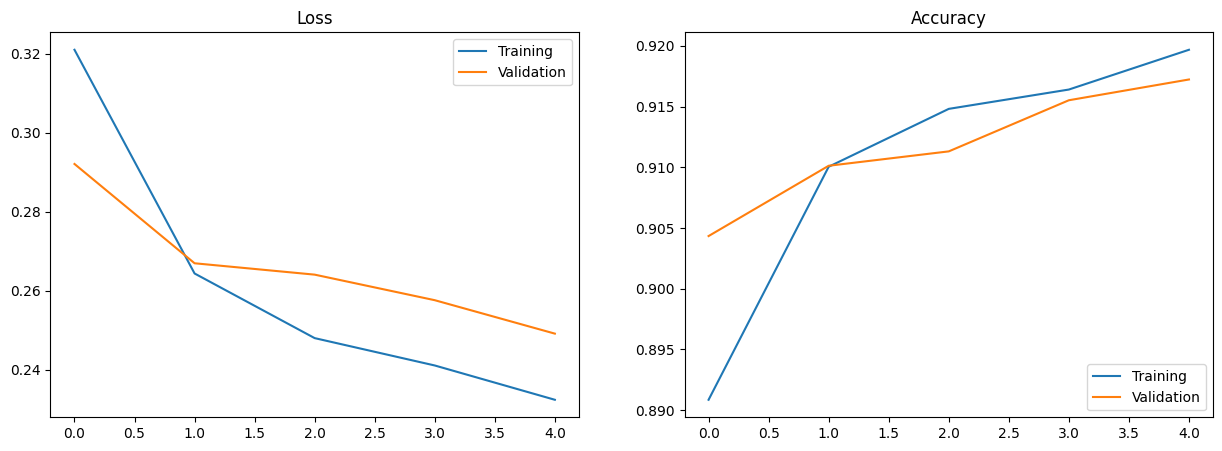

In [ ]:
# Loss와 Accuracy 확인
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [ ]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 92.0%
Accuracy Test data: 91.7%
Training time: 122.4s


일반 RNN 모델은 시계열 데이터를 순차적으로 처리합니다. <br>
Attention 매커니즘을 추가하면서 입력 시퀀스에 특정 부분에 가중치를 두게 됩니다. <br>
이를 통해 특정 단어들이 중요한 역할을 할 때 반영하면서 RNN의 종속성 문제를 완화합니다. <br>
최종적으로 Attention 메커니즘을 적용한 RNN은 91.7% 정확도가 나온 것을 확인하였습니다. <br>

### Deep Learning - With Bert Language Model
해당 예시에 있는 DitstillBERT을 활용하여 task을 진행해보겠습니다. <br>
데이터 셋 전처리도 RNN 방식과 동일하게 진행합니다. <br>

In [ ]:
# Renaming, Input -> X, Output -> y
X_bert_train_data = train_dataset['text']
y_bert_train_class = train_dataset['label']

X_bert_test_data = test_dataset['text']
y_bert_test_class = test_dataset['label']

# Convert labels into a one-hot vector of size 4 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_bert_train_class)  # Train 데이터에 대해 인코더 학습
y_bert_train = lab.transform(y_bert_train_class)
y_bert_test = lab.transform(y_bert_test_class)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + str(y_bert_train_class[n]) + ' is ', y_bert_train[n])

Coding of labels into a one-hot vector: 3 is  [0 0 0 1]


In [ ]:
print("Shape of y_bert_train:", y_bert_train.shape)
print("Shape of y_bert_test:", y_bert_test.shape)

Shape of y_bert_train: (120000, 4)
Shape of y_bert_test: (7600, 4)


DistillBERT 모델은 토크나이저를 제공해줍니다. <br>
Train 데이터셋과 Validation 데이터 셋을 tokenization하기 위해 코드를 수정합니다. <br>
max_length을 너무 길게 하면 패딩이 많이 되어 불필요한 값들이 학습될 수 있기에, 최대한 줄였습니다. <br>

In [ ]:
# distil-bert tokenizer
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Train data tokenization
X_bert_train = [
    tokenizer_bert(text, padding='max_length', max_length=64, truncation=True)['input_ids']
    for text in train_dataset['text']
]
X_bert_train = np.array(X_bert_train, dtype='int32')  # 정수형 배열로 변환

# Test data tokenization
X_bert_test = [
    tokenizer_bert(text, padding='max_length', max_length=64, truncation=True)['input_ids']
    for text in test_dataset['text']
]
X_bert_test = np.array(X_bert_test, dtype='int32')  # 정수형 배열로 변환

In [ ]:
print('Shape of training data: ',X_bert_train.shape)
print('Shape of test data: ',X_bert_test.shape)

Shape of training data:  (120000, 64)
Shape of test data:  (7600, 64)


In [ ]:
config = transformers.DistilBertConfig(dropout=0.2) # 과적합 방지 및 원활한 학습을 위해 attention dropout은 제거
dbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Let's create a sampe of size 4 from the training data
sample = tf.convert_to_tensor(X_bert_train[0:4], dtype=tf.int32)
print('Object type: ', type(dbert(sample)))
print('Output format (shape): ',dbert(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
Output format (shape):  (4, 64, 768)
Output used as input for the classifier (shape):  (4, 768)


In [ ]:
input_ids_in = layers.Input(shape=(64,), name='input_token', dtype='int32')

x = dbert(input_ids=input_ids_in)[0][:,0,:] # DistilBERT 적용
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(4, activation='softmax', name='classification')(x)

dmodel = models.Model(inputs=input_ids_in, outputs = x)

dmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
dmodel.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 64)]              0         
                                                                 
 tf_distil_bert_model_8 (TFD  TFBaseModelOutput(last_h  66362880 
 istilBertModel)             idden_state=(None, 64, 7            
                             68),                                
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem_9   (None, 768)              0         
 (SlicingOpLambda)                                               
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                          

In [ ]:
# Train the model
start_time = datetime.now()
history = dmodel.fit(X_bert_train, y_bert_train, batch_size=64, shuffle=True, epochs=30, validation_data=(X_bert_test, y_bert_test))
end_time = datetime.now()

training_time_bert = (end_time - start_time).total_seconds()

Epoch 1/30
  27/1875 [..............................] - ETA: 1:46 - loss: 0.9706 - accuracy: 0.6331

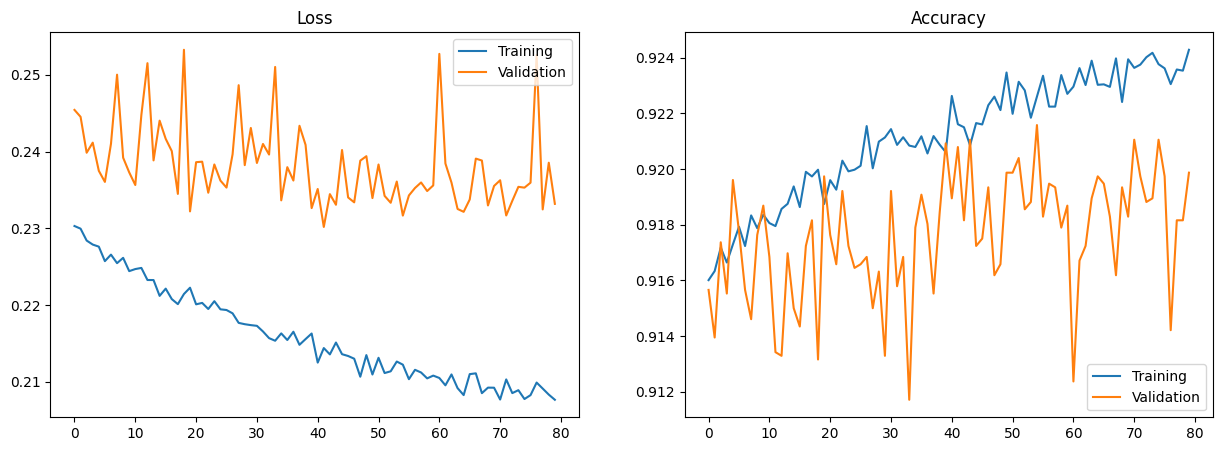

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [ ]:
accuracy_bert = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_bert, training_time_bert/60))

Accuracy Training data: 92.4%
Accuracy Test data: 92.0%
Training time: 8951.8s (or 149.2 minutes)


BERT 모델은 Transformer의 Encoder 구조를 기반으로 합니다. <br>
입력 시퀀스의 모든 단어 간의 관계를 학습하며 Self-Attention 메커니즘을 통해 문맥의 양방향 정보를 처리합니다. <br>
최종적으로 BERT 모델은 92.0%의 정확도가 나온 것을 확인하였습니다.

### 결론 - RNN과 BERT의 비교
Attention을 추가한 RNN과 BERT 모델의 Accuracy, 학습시간을 비교해보았습니다.

In [ ]:
method = ['RNN', 'BERT']
accuracy = [accuracy_rnn, accuracy_bert]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [round(training_time_rnn,1), round(training_time_bert,1)]
training_time_rounded = [round(tt,1) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list(training_time /min(training_time))
training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Method' : method,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

,Method,Accuracy,Training Time [s],Training Time [x]
0,RNN,91.9%,124.4,1.0x
1,BERT,91.7%,3355.6,27.0x


주어진 Task에서는 문장의 길이가 100자 이하로 복잡하지 않습니다. <br>
이에 Attention을 추가한 RNN 모델도 훌륭한 성능을 보이는 것을 확인하였습니다. <br>
BERT 모델은 하이퍼 파라미터 수정에 따라 결과값이 차이가 나는 것을 확인하였으며, RNN에 비해 많은 시간을 요구하였습니다. <br>
어렵지 않은 task에서는 RNN에 Attention을 추가하는 것만으로도 충분한 성능을 볼 수 있는 것을 알 수 있었습니다. <br>